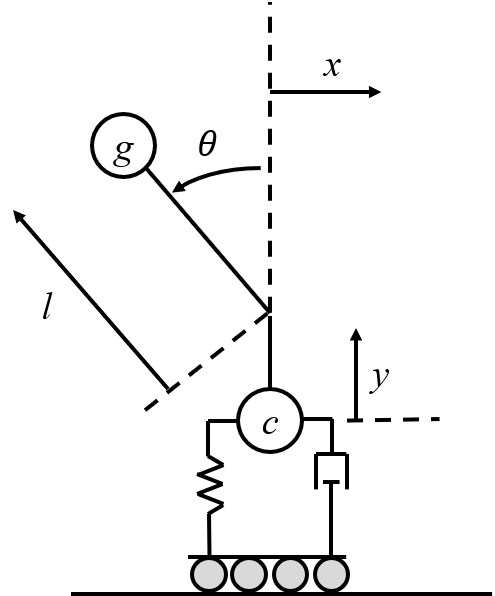

First we import the NumPy and SymPy mechanics modules in python. NumPy provides an extensive set of numerical analysis funtions, while SymPy is a symbolic coding environment with the mechanics module standardizing various kinematic transformations and and equation of motion generation. The IPython display modules are imported to generate typeset equations suitable for document publication.

In [1]:
import numpy as np
from sympy import *
from sympy.physics.mechanics import *
from IPython.display import display, Latex
#init_printing(use_latex='mathjax')

To begin the dynamics model formulation, we first define the generalized coordinates. The player is defined as a point mass located at point $p$, with positions $(x, y)$ defined relative to the origin in the horizontal and vertical directions, respectively. The stool is also defined as a point mass located at point $s$, which is translated and rotated relative to the player with a transformation (to be described later) requiring an arm extension length $l$ and stool tilt angle $θ$. These four variables form the generalized coordinate vector $\boldsymbol{q}$. 

The SymPy Mechanics `dynamicsymbols` function is used to define these as symbolic variables that are time-varying, and therefore candidate degrees-of-freedom (DOFs). Notably, the left hand side of the equation are the variables to be used in the source code, where `th` is used in place of $θ$. When typing code that references the tilt angle, `th` will be used, whereas when the `display` function is called to typeset the equation, the more visually appealing $θ$ is used, as seen below. Also note that the display adds the $(t)$ to each variable, indicating it is time-varying. The chained assignment operators (i.e. `a = b = c`) are used such that in the source code the variables `generalized_coords` and `q` can be used interchangeably.

In [2]:
x, y, l, th = dynamicsymbols('x y l θ')
generalized_coords = q = Matrix([x, y, l, th])
display(q)

Matrix([
[x(t)],
[y(t)],
[l(t)],
[θ(t)]])

We will also need the derivatives of these coordinates with respect to time, which are obtained by calling the `dynamicsymbols` function with the second argument `1` indicating the first derivative.

In [3]:
dxdt, dydt, dldt, dthdt = dynamicsymbols('x y l θ', 1)
ddt_generalized_coords = dqdt = Matrix([dxdt, dydt, dldt, dthdt])
display(dqdt)

Matrix([
[Derivative(x(t), t)],
[Derivative(y(t), t)],
[Derivative(l(t), t)],
[Derivative(θ(t), t)]])

Initial values for the generalized coordinates are represented by a subscript $0$, where $\boldsymbol{q}_0 = (x_0, y_0, l_0, θ_0)^T$. In SymPy, these are defined using a call to the `symbols` function, which declares them as constants. As before, a slight variation is used for the variable representation in the source code versus in typesetting, where for the latter the underscore is used to ensure that these are typeset as a subscript.

In [4]:
x0, y0, l0, th0 = symbols('x_0 y_0 l_0 θ_0')
q0 = Matrix([x0, y0, l0, th0])
display(q0)

Matrix([
[x_0],
[y_0],
[l_0],
[θ_0]])

To facilitate equation of motion generation using Kane's method, we will also define a set of generalized speeds. In this case, we will use substition variables $u = \frac{\partial x}{\partial t}$, $v = \frac{\partial y}{\partial t}$, $w = \frac{\partial l}{\partial t}$, and $ω = \frac{\partial θ}{\partial t}$.

In [5]:
u, v, w, omeg = dynamicsymbols('u v w ω')
generalized_speeds = s = Matrix([u, v, w, omeg])
display(generalized_speeds)

Matrix([
[u(t)],
[v(t)],
[w(t)],
[ω(t)]])

A kinematic equation will be used in Kane's method to define the equality $\boldsymbol{s} = \frac{\partial \boldsymbol{q}}{\partial t}$, equivalently $\boldsymbol{s} - \frac{\partial \boldsymbol{q}}{\partial t} = \boldsymbol$

In [6]:
kinematic_equation = s - dqdt
display(kinematic_equation)

Matrix([
[u(t) - Derivative(x(t), t)],
[v(t) - Derivative(y(t), t)],
[w(t) - Derivative(l(t), t)],
[ω(t) - Derivative(θ(t), t)]])

In [7]:
dx, dy, dl, dth = symbols('dx dy dl dθ')
ddx, ddy, ddl, ddth = symbols('ddx ddy ddl ddθ')
dq = Matrix([dx, dy, dl, dth])
ddq = Matrix([ddx, ddy, ddl, ddth])

Next we define the constants, including masses $m_p$ and $m_s$ of the player and stool, an offset distance $d$ between the player center of mass and the point about which the stool rotates, the gravitational constant $'g'$ (represented by `grav` in source code). 

In [8]:
mp, ms, d, grav, t = symbols('m_p m_s d g t')

The spring coefficients $K_y$, $K_l$, and $K_θ$ introduce generalized forces into the system proportional to the subscripted coordinate minus its initial value. 

In [9]:
Ky, Kl, Kt = symbols('K_y K_l K_θ')
generalized_spring_forces = QK =  Matrix([0, Ky * (y0 - y), Kl * (l0 - l), Kt * (th0 - th)])
display(generalized_spring_forces)

Matrix([
[               0],
[K_y*(y_0 - y(t))],
[K_l*(l_0 - l(t))],
[K_θ*(θ_0 - θ(t))]])

Likewise, the damping constants $C_x$, $C_y$, $C_l$, and $C_θ$ induce generalized forces proportional to derivatives with respect to time of the generalized coordinates.

In [10]:
Cx, Cy, Cl, Cth = symbols('C_x C_y C_l C_θ')
generalized_damping_forces = QC = Matrix([- Cx * dxdt, - Cy * dydt, - Cl * dldt, - Cth * dthdt])
display(generalized_damping_forces)

Matrix([
[-C_x*Derivative(x(t), t)],
[-C_y*Derivative(y(t), t)],
[-C_l*Derivative(l(t), t)],
[-C_θ*Derivative(θ(t), t)]])

The generalized input forces $Q_x$, represent the control variables, from either player inputs or the computer control logic algorithm.

In [11]:
Qx, Qy, Ql, Qth = symbols('Q_x Q_y Q_l Q_θ')
generalized_input_forces = Q = Matrix([Qx, Qy, Ql, Qth])
display(Q)

Matrix([
[Q_x],
[Q_y],
[Q_l],
[Q_θ]])

Create the origin frame `O` and stool frame `S`, and transformation matrxi

In [12]:
O = ReferenceFrame('R')
S = ReferenceFrame('S')
S.orient(R, 'Axis', [th, R.z])
display(S.dcm(R))

NameError: name 'R' is not defined

Create points for the inertial reference 'O', player 'p', and stool 's'

In [ ]:
O = Point('O')
O.set_vel(R, 0)
p = Point('p')
s = Point('s')

Define the vectors to the player and stool

In [ ]:
rp = x * R.x + y * R.y
rs = x * R.x + (y + d) * R.y + l * S.y
p.set_pos(O, x * R.x + y * R.y)
s.set_pos(p, d * R.y + l * S.y)
print('The player position expressed in the R frame is')
display(rp)
print('The stool position expressed in the R frame is')
display(rs.express(R))
# display(p.pos_from(O))
# display(s.pos_from(O).express(R))

Calculate velocities of the player and stool

In [ ]:
vp = rp.dt(R)
vs = rs.dt(R)
print('The player velocity expressed in the R frame is')
display(vp)
print('The stool velocity expressed in the R frame is') 
display(vs.express(R))

Calculate kinetic and potential energies, and lagrangian

In [ ]:
T = simplify( 0.5 * mc * dot(vp, vp) + 0.5 * mg*dot(vs, vs) )
V = mc * grav * y + mg * grav * (y + d + l * cos(th)) + 0.5 * Ky * (y - y0)**2 + 0.5 * Kl * (l-l0)**2 + 0.5 * Kt * th**2
L = T - V
display(L)

Calculate left hand side of equations of motion using Lagrange method

In [ ]:
e_x = simplify(diff(diff(L,Derivative(x, t)), t) - diff(L, x))
e_y = simplify(diff(diff(L,Derivative(y, t)), t) - diff(L, y))
e_l = simplify(diff(diff(L,Derivative(l, t)), t) - diff(L, l))
e_th = simplify(diff(diff(L,Derivative(th, t)), t) - diff(L, th))

display(e_x)

Substitute shorter variable names in for the derivatives

In [ ]:
e_x = e_x.subs(Derivative(x, (t, 2)), ddx).subs(Derivative(y, (t, 2)), ddy).subs(Derivative(l, (t, 2)), ddl).subs(Derivative(th, (t, 2)), ddth).subs(Derivative(l, t), dl).subs(Derivative(th, t), dth)
e_y = e_y.subs(Derivative(x, (t, 2)), ddx).subs(Derivative(y, (t, 2)), ddy).subs(Derivative(l, (t, 2)), ddl).subs(Derivative(th, (t, 2)), ddth).subs(Derivative(l, t), dl).subs(Derivative(th, t), dth)
e_l = e_l.subs(Derivative(x, (t, 2)), ddx).subs(Derivative(y, (t, 2)), ddy).subs(Derivative(l, (t, 2)), ddl).subs(Derivative(th, (t, 2)), ddth).subs(Derivative(l, t), dl).subs(Derivative(th, t), dth)
e_th = e_th.subs(Derivative(x, (t, 2)), ddx).subs(Derivative(y, (t, 2)), ddy).subs(Derivative(l, (t, 2)), ddl).subs(Derivative(th, (t, 2)), ddth).subs(Derivative(l, t), dl).subs(Derivative(th, t), dth)
lhs = Matrix([e_x, e_y, e_l, e_th])

print(e_x)
print()
print(e_y)
print()
print(e_l)
print()
print(e_th)
print()

Calculate mass matrix, and its inverse

In [ ]:
#M = Matrix([[mc+mg, 0, -mg*sin(th), -mg*l*cos(th)],
#            [0, mc+mg, mg*cos(th), -mg*l*sin(th)],
#            [-mg*sin(th), mg*cos(th), mg, 0], 
#            [-mg*l*cos(th), -mg*l*sin(th), 0, mg*l**2]])
#pprint(M)
print()
M = Matrix([[diff(e_x, ddx), diff(e_x, ddy), diff(e_x, ddl), diff(e_x, ddth)],
            [diff(e_y, ddx), diff(e_y, ddy), diff(e_y, ddl), diff(e_y, ddth)], 
            [diff(e_l, ddx), diff(e_l, ddy), diff(e_l, ddl), diff(e_l, ddth)], 
            [diff(e_th, ddx), diff(e_th, ddy), diff(e_th, ddl), diff(e_th, ddth)]])
Minv = simplify(M.inv())
MinvQ = Minv*Q
pprint(M)
print()
pprint(Minv)
print()
print(str(MinvQ[0]).replace('mc', 'p.mc').replace('l(t)', 'gs.lp[k]').replace('th(t)', 'gs.tp[k]').replace('Qx', 'Q[0]').replace('Qy', 'Q[1]').replace('Ql', 'Q[2]').replace('Qth', 'Q[3]'))
print()
print(str(MinvQ[1]).replace('mc', 'p.mc').replace('l(t)', 'gs.lp[k]').replace('th(t)', 'gs.tp[k]').replace('Qx', 'Q[0]').replace('Qy', 'Q[1]').replace('Ql', 'Q[2]').replace('Qth', 'Q[3]'))
print()
print(str(MinvQ[2]).replace('mc', 'p.mc').replace('l(t)', 'gs.lp[k]').replace('th(t)', 'gs.tp[k]').replace('Qx', 'Q[0]').replace('Qy', 'Q[1]').replace('Ql', 'Q[2]').replace('Qth', 'Q[3]'))
print()
print(str(MinvQ[3]).replace('mc', 'p.mc').replace('l(t)', 'gs.lp[k]').replace('th(t)', 'gs.tp[k]').replace('Qx', 'Q[0]').replace('Qy', 'Q[1]').replace('Ql', 'Q[2]').replace('Qth', 'Q[3]'))

Pre-multiply by the inverse of the mass matrix to obtain an integrable system of equations

In [ ]:
rhs = simplify(M.inv()*(-lhs + M*ddq - C + Q))
#pprint(rhs)

Replace strings in rhs to obtain the system in python code that is paste-able into scripts

In [ ]:
#repset = ['l0', 'p.l0', 'y0', 'p.y0']
#rhs_str = []
# for k in range(4):
    #for n in range(2):
    #    rhs_str[k] = rhs_str.replace(repset[n][0], repset[n][1]) 
    #print('ddq['+str(k)+'] = '+rhs_str[k])
st, ct = symbols('st ct')    
for k in range(4):
    print()
    print('ddq['+str(k)+'] = '+str(rhs[k]).replace('l0','p.l0').replace('y0','p.y0').replace('grav','p.g').replace('sin(th(t))','s').replace('cos(th(t))','c').replace('y(t)','yp[k]').replace('dx','dxp[k]').replace('dy','dyp[k]').replace('l(t)','lp[k]').replace('dl','dlp[k]').replace('th(t)','tp[k]').replace('dth','dtp[k]').replace('Cl','p.Cl').replace('Cth','p.Ct').replace('Cx','p.Cx').replace('Cy','p.Cy').replace('Ky','p.Ky').replace('Kl','p.Kl').replace('Kt','p.Kt').replace('mc','p.mc').replace('mg','p.mg'))
    
    